In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)



Mounted at /content/gdrive


In [9]:
folder_name = '2025-12-11_Formation_IP/'
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + folder_name

In [2]:
# imports
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
import time
import pymc as pm
import arviz as az

In [3]:
def get_95CI(signal, alpha=5.0):
    """Computes the (default to 95%) confidence intervals of a sequential signal.

    Parameters
    ----------
    signal : {array-like} of shape (n_samples, n_timesteps).
    The matrix of samples. Each row represents a sample, while each column is associated to a timestep.

    alpha : float.
    1 - CI_range, where CI_range represents the range of the confidence interval.

    Returns
    -------
    CI95_lower : {array} of shape (n_timesteps, ).
    The lower bound of the (1 - alpha) confidence interval.

    CI95_upper : {array} of shape (n_timesteps, ).
    The upper bound of the (1 - alpha) confidence interval.
    """
    CI95_lower = []
    CI95_upper = []

    for timestep in range(signal.shape[1]):

        drawn_at_time_t = signal[:,timestep] # Gather the samples at time t
        lower_p = alpha / 2.0 # Computes the lower bound
        lower = np.percentile(drawn_at_time_t, lower_p) # Retrieves the observation at the lower percentile index
        upper_p = (100 - alpha) + (alpha / 2.0) # Computes the upper bound
        upper = np.percentile(drawn_at_time_t, upper_p) # Retrieves the observation at the upper percentile index

        CI95_lower.append(lower)
        CI95_upper.append(upper)

    return np.array(CI95_lower), np.array(CI95_upper)


def normal_distribution_pdf(x, loc=0, scale=1):
    """Computes the normal probability density function (PDF) for each value in the input vector x.
    NB : Empirically much faster than scipy's, probably related to sample size I guess.

    Parameters
    ----------
    x : {array} of shape (n_samples, ).
    The array upon which the PDF is going to be applied.

    loc : float.
    The mean of the normal distribution.

    scale : float.
    The standard deviation of the normal distribution.

    Returns
    -------
    pdf : {array} of shape (n_samples, ).
    The PDF related to the input vector x.
    """
    A = 1 / (scale * np.sqrt(2 * np.pi))
    B = - (1/2) * ((x - loc)/ scale) ** 2

    return A * np.exp(B)

def approx_standard_normal_cdf_sw(x, loc=0, scale=1):
    """Computes the normal cumulative distribution function (CDF) for each value in the input vector x,
    using Page's approximation formula.

    Parameters
    ----------
    x : {array} of shape (n_samples, ).
    The array upon which the CDF is going to be applied.

    loc : float.
    The mean of the normal distribution.

    scale : float.
    The standard deviation of the normal distribution.

    Returns
    -------
    cdf : {array} of shape (n_samples, ).
    The CDF related to the input vector x.
    """
    xx = (x - loc) / scale
    return 0.5 * (1.0 + np.tanh(np.sqrt(2.0 / np.pi) * (xx + 0.044715 * xx**3)))

def censored_normal_logcdf(lod, eps, latent):
    """Computes the logarithm of the normal cumulative distribution function (CDF) for each observation in the input vector lod,
    based on the assumption that lod|latent \sim \mathcal{N}(latent, eps**2) in pyMC's framework.

    Parameters
    ----------
    lod : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    eps : float.
    The standard deviation of the observations w.r.t the latent variable.

    latent : {array} of shape (n_steps, ).
    The array of the sequential values for the latent variable.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector lod.
    """
    return pm.logcdf(pm.Normal.dist(mu=latent, sigma=eps), lod)

def censored_uniform_logcdf(lod, a, b):
    """Computes the logarithm of the uniform cumulative distribution function (CDF) for each observation in the input vector lod,
    based on the assumption that lod|latent \sim \mathcal{U}(a, b) in pyMC's framework.

    Parameters
    ----------
    lod : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    a : float.
    Lower bound of the uniform distribution.

    b : {array} of shape (n_steps, ).
    Upper bound of the uniform distribution.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector lod.
    """
    return pm.logcdf(pm.Uniform.dist(lower=a, upper=b), lod)


def censored_normal_logcdf_LoQ(loqd, eps, latent):
    """Computes the logarithm of the normal cumulative distribution function (CDF) for each observation in the input vector value,
    based on the assumption that value|latent \sim \mathcal{N}(latent, eps**2) in pyMC's framework.

    Parameters
    ----------
    value : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    eps : float.
    The standard deviation of the observations w.r.t the latent variable.

    latent : {array} of shape (n_steps, ).
    The array of the sequential values for the latent variable.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector value.
    """
    contrib_a = pm.math.exp(censored_normal_logcdf(loqd[:,0], eps, latent))
    contrib_b = pm.math.exp(censored_normal_logcdf(loqd[:,1], eps, latent))
    return pm.math.log(contrib_b - contrib_a)

def censored_uniform_logcdf_LoQ(loqd, a, b):
    """Computes the logarithm of the uniform cumulative distribution function (CDF) for each observation in the input vector value,
    based on the assumption that value|latent \sim \mathcal{U}(a, b) in pyMC's framework.

    Parameters
    ----------
    value : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    a : float.
    Lower bound of the uniform distribution.

    b : {array} of shape (n_steps, ).
    Upper bound of the uniform distribution.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector value.
    """
    contrib_a = pm.math.exp(censored_uniform_logcdf(loqd[:,0], a, b))
    contrib_b = pm.math.exp(censored_uniform_logcdf(loqd[:,1], a, b))
    return pm.math.log(contrib_b - contrib_a)

class SCOU():
    """
    Bayesian implementation of the SCOU algorithm.

    SCOU is an extended Kalman Smoother, taking into consideration
    left-censored values as well as outliers.

    Parameters
    ----------
    p_out_frozen : bool, default=False
        Whether to estimate the a priori outlier probability. If set
        to False, a deterministic value will be used.

    p_out_deterministic : float, default=None
        The value to be used for p_out if p_out_frozen is set to True.

    tuning_iters : int, default=4000
        The number of tuning iterations used for the NUTS MCMC sampler.

    sampling_iters : int, default=2000
        The number of sampling iterations used for the NUTS MCMC sampler.

    nb_chains : int, default=3
        The number of Markov chains used for the NUTS MCMC sampler.

    export_chains : bool, default=False
        Whether to export the chains of parameters in a *.nc file.

    export_name : string, default='default.nc'
        The name of the export file if export_chains is set to True.

    RW_order : {1, 2}, default=1
        The order of the gaussian random walk of the underlying process.

    Attributes
    ----------
    latent_posterior_distribution : array of shape (n_samples, n_steps)
        The posterior distribution of the latent variable.

    muX : array of shape (n_steps, )
        The average signal of the latent variable, performed over all samples.

    CIU : array of shape (n_steps, )
        The upper bound of the 95% CI of the latent variable.

    CIL : array of shape (n_steps, )
        The lower bound of the 95% CI of the latent variable.

    pointwise_pout : array of shape (n_steps, )
        The posterior probability of each observation to be an outlier.

    SCOU_model :

    SCOU_traces :

    T_ronde :

    borne_inf :

    borne_sup :

    unobserved_indexes :



    See Also
    --------

    Notes
    -----
    This algorithm was tailor-made to meet the expectations of the Obepine research consortium
    during the Covid-19 pandemic in terms of microbiological data processing.

    References
    ----------

    .. [1] M. Courbariaux et al., "A Flexible Smoother Adapted to Censored Data
           With Outliers and Its Application to SARS-CoV-2 Monitoring in Wastewater",
           Frontiers in Applied Mathematics and Statistics, 2022.
           https://doi.org/10.3389/fams.2022.836349

    Examples
    --------
    >>> TODO
    """

    def __init__(self, observations,
                 censoring_threshold_lod_vect=np.array([]),
                 censoring_threshold_loq_vect=np.array([]),
                 p_out_frozen=False,
                 p_out_deterministic=None,
                 tuning_iters=4000,
                 sampling_iters=2000,
                 nb_chains=3,
                 export_chains=False,
                 export_name='default.nc',
                 RW_order=1):

        self.observations = observations
        self.censoring_threshold_lod_vect = censoring_threshold_lod_vect
        self.censoring_threshold_loq_vect = censoring_threshold_loq_vect
        self.n_steps = self.observations.shape[0]
        self.rng = np.random.default_rng(666)
        self.tuning_iters = tuning_iters
        self.sampling_iters = sampling_iters
        self.nb_chains = nb_chains
        self.export_name = export_name
        self.export_chains = export_chains
        self.p_out_frozen = p_out_frozen
        self.p_out_deterministic = p_out_deterministic
        self.RW_order = RW_order


    def obs_discrimination(self):
        """Defines the set of observations, whether they are censored or not, which timesteps are not observed
        and the lower and upper bounds of the uniform distribution.

        """
        self.unobserved_indexes = np.where(np.isnan(self.observations))[0]

        if len(self.censoring_threshold_loq_vect)>0:
            self.observations_below_LoD = np.where(self.observations<=self.censoring_threshold_lod_vect)[0]
            self.observations_above_LoQ = np.where(self.observations>self.censoring_threshold_loq_vect)[0]
            self.observations_between_LoQD = np.where((self.observations>self.censoring_threshold_lod_vect) & (self.observations<=self.censoring_threshold_loq_vect))[0]
        else:
            self.observations_below_LoD = np.where(self.observations<=self.censoring_threshold_lod_vect)[0]
            self.observations_above_LoQ = np.where(self.observations>self.censoring_threshold_lod_vect)[0]
            self.observations_between_LoQD = np.array([])

        self.T_ronde = np.setdiff1d(np.arange(self.observations.shape[0]), self.unobserved_indexes)
        self.borne_inf, self.borne_sup = np.nanmin(self.observations) - 2*np.nanstd(self.observations), np.nanmax(self.observations) + 2*np.nanstd(self.observations)


    def model_definition(self):
        """Defines the model parameters and observation in pyMC's framework.

        """
        self.obs_discrimination()

        with pm.Model() as self.SCOU_model:
            ### ----- Priors definition ----- ###
            sig = pm.InverseGamma('sig', alpha=2, beta=1) # Latent process innovation's drift
            eps = pm.InverseGamma('eps', alpha=2, beta=1) # Observations standard deviation w.r.t latent process
            if self.p_out_frozen:
                p_out = self.p_out_deterministic # Outliers a priori proportion can be frozen to a deterministic value
            else:
                p_out = pm.Beta('p_out', alpha=2, beta=5) # Outliers a priori proportion

            init_mean = np.nanmean(self.observations)
            init_std = 5
            init_dist = pm.Normal.dist(init_mean, init_std, shape=self.n_steps)
            if self.RW_order==1:
                latent = pm.AR("latent", rho=np.array([1]), sigma=sig, shape=self.n_steps, init_dist=init_dist) # Latent process X[t] defined as (AR(1))
            elif self.RW_order==2:
                latent = pm.AR("latent", rho=np.array([2, -1]), sigma=sig, shape=self.n_steps, init_dist=init_dist) # Latent process X[t] defined as (AR(2))

            ### ----- Uncensored data handling ----- ###
            normal_component = pm.Normal.dist(mu=latent[self.observations_above_LoQ], sigma=eps) # Gaussian component for uncensored data
            outlier_component = pm.Uniform.dist(lower=self.borne_inf, upper=self.borne_sup) # Uniform component for outliers

            ### -----  Uncensored data mixture model definition ----- ###
            obs_uncensored = pm.Mixture(
                'obs_uncensored',
                w=[1 - p_out, p_out],
                comp_dists=[normal_component, outlier_component],
                observed=self.observations[self.observations_above_LoQ]
            )

            ### ----- LoD censored data handling ----- ###
            normal_LoD_component = pm.DensityDist.dist(
                eps, latent[self.observations_below_LoD],
                logp=censored_normal_logcdf,
                logcdf=censored_normal_logcdf,
                class_name="normal_LoD_component"
            )

            outlier_LoD_component = pm.DensityDist.dist(
                self.borne_inf, self.borne_sup,
                logp=censored_uniform_logcdf,
                logcdf=censored_uniform_logcdf,
                class_name="outlier_LoD_component"
            )

            ### -----  Censored data mixture model definition ----- ###
            obs_LoD = pm.Mixture(
                'obs_LoD',
                w=[1 - p_out, p_out],
                comp_dists=[normal_LoD_component, outlier_LoD_component],
                observed=self.observations[self.observations_below_LoD]
            )

            if len(self.censoring_threshold_loq_vect)>0:
                ### ----- LoQ censored data handling ----- ###
                normal_LoQ_component = pm.DensityDist.dist(
                    eps, latent[self.observations_between_LoQD],
                    logp=censored_normal_logcdf_LoQ,
                    logcdf=censored_normal_logcdf_LoQ,
                    class_name="normal_LoQ_component"
                )

                outlier_LoQ_component = pm.DensityDist.dist(
                    self.borne_inf, self.borne_sup,
                    logp=censored_uniform_logcdf_LoQ,
                    logcdf=censored_uniform_logcdf_LoQ,
                    class_name="outlier_LoD_component"
                )

                loqd_stacked_obs = np.vstack((self.censoring_threshold_lod_vect[self.observations_between_LoQD],
                                           self.observations[self.observations_between_LoQD])).T

                ### -----  Censored data mixture model definition ----- ###
                obs_LoQ = pm.Mixture(
                    'obs_LoQ',
                    w=[1 - p_out, p_out],
                    comp_dists=[normal_LoQ_component, outlier_LoQ_component],
                    observed=loqd_stacked_obs
                )

    def fit(self):
        """Computes the MCMC estimation of the model parameters using the NUTS sampler.

        """
        self.model_definition()

        # Inférence
        with self.SCOU_model:
            self.SCOU_traces = pm.sample(self.sampling_iters, tune=self.tuning_iters,
                                    chains=self.nb_chains,
                                    return_inferencedata=True,
                                    random_seed=self.rng,
                                    cores=4)

        self.params = ['sig', 'eps']
        if not self.p_out_frozen:
            self.params.append('p_out')

        print("Raw summary:")
        print(az.summary(self.SCOU_traces, var_names=self.params))
        self.params_summary = az.summary(self.SCOU_traces, var_names=self.params)

        if self.export_chains:
            self.SCOU_traces.to_netcdf(self.export_name)

    def predict(self, selected_chains):
        """Computes the latent distribution, as well as its mean and 95% confidence intervals and pointwise outlier probabilities
        for a subset of selected chains.

        Parameters
        ----------
        selected_chains : {array} of shape (n_selected_chains, ).
        The array of indexes of the selected chains, ranging from 0 to self.nb_chains.
        """
        self.n_samples = len(selected_chains)*self.sampling_iters
        self.latent_posterior_distribution = self.SCOU_traces['posterior']['latent'].values[selected_chains].reshape(self.n_samples, -1)
        self.muX = self.latent_posterior_distribution.mean(axis=0)
        self.CIL, self.CIU = get_95CI(self.latent_posterior_distribution)
        self.compute_pointwise_outlier_probabilities(selected_chains)

        print("Best chain combination summary:")
        print(az.summary(self.SCOU_traces.sel(chain=selected_chains), var_names=self.params))

    def compute_pointwise_outlier_probabilities(self, selected_chains):
        """Computes the pointwise outlier probabilities for a subset of selected chains.

        Parameters
        ----------
        selected_chains : {array} of shape (n_selected_chains, ).
        The array of indexes of the selected chains, ranging from 0 to self.nb_chains.
        """
        nb_draws = self.SCOU_traces['posterior']['eps'].values[selected_chains].shape[1] * len(selected_chains)

        self.pointwise_pout = np.ones(self.observations.shape[0]) * np.nan
        self.pointwise_pout_dist = np.ones((self.observations.shape[0], nb_draws)) * np.nan

        # Vectorizing these computations first so that we don't have to repeat them in the next for loop:
        this_partial_emission_vector = np.ones(self.observations.shape[0]) * (1/(self.borne_sup - self.borne_inf))
        this_partial_emission_vector[self.observations_below_LoD] = ((self.censoring_threshold_lod_vect[self.observations_below_LoD] - self.borne_inf)/(self.borne_sup - self.borne_inf))
        if len(self.censoring_threshold_loq_vect)>0:
            this_partial_emission_vector[self.observations_between_LoQD] = ((self.censoring_threshold_loq_vect[self.observations_between_LoQD] - self.censoring_threshold_lod_vect[self.observations_between_LoQD])/(self.borne_sup - self.borne_inf))

        for this_timestep in self.T_ronde:
            xhat_t = self.observations[this_timestep]
            x_t = self.SCOU_traces['posterior']['latent'].values[selected_chains].reshape(len(selected_chains)*self.sampling_iters, -1)[:, this_timestep]
            this_epsilon = self.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(len(selected_chains)*self.sampling_iters, )[:,]

            if self.p_out_frozen:
                this_pout = self.p_out_deterministic
            else:
                this_pout = self.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(len(selected_chains)*self.sampling_iters, )[:,]

            if this_timestep in self.observations_below_LoD:
                num = this_pout * this_partial_emission_vector[this_timestep]
                denom_not_outlier = (1-this_pout) * approx_standard_normal_cdf_sw(xhat_t, x_t, this_epsilon)
                denom = denom_not_outlier + num

            elif this_timestep in self.observations_between_LoQD:
                num = this_pout * this_partial_emission_vector[this_timestep]
                cdf_diff = approx_standard_normal_cdf_sw(xhat_t, x_t, this_epsilon) - approx_standard_normal_cdf_sw(self.censoring_threshold_lod_vect[this_timestep], x_t, this_epsilon)
                denom_not_outlier = (1-this_pout) * cdf_diff
                denom = denom_not_outlier + num

            elif this_timestep in self.observations_above_LoQ:
                num = this_pout * this_partial_emission_vector[this_timestep]
                denom_not_outlier = (1-this_pout) * normal_distribution_pdf(xhat_t, x_t, this_epsilon)
                denom = denom_not_outlier + num

            num = np.array(num)
            denom = np.array(denom)

            self.pointwise_pout_dist[this_timestep] = (num/denom)
            self.pointwise_pout[this_timestep] = np.mean(self.pointwise_pout_dist[this_timestep])

    def visualize_latents(self, selected_chains):
        """Plots the mean of the distributions of the latent variable for each chain on a first figure.
        Plots the same distribution only for a subset of selected chains on a second figure.

        Parameters
        ----------
        selected_chains : {array} of shape (n_selected_chains, ).
        The array of indexes of the selected chains, ranging from 0 to self.nb_chains.
        """
        plt.figure()
        for i in range(self.nb_chains):
            plt.plot(self.SCOU_traces['posterior']['latent'][i].mean(axis=0), label=i)

        plt.title('Raw chains')
        plt.legend()
        plt.show()

        plt.figure()
        for i in selected_chains:
            plt.plot(self.SCOU_traces['posterior']['latent'][i].mean(axis=0), label=i)

        plt.title('Optimized chains')
        plt.legend()
        plt.show()

<>:87: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\s'
<>:132: SyntaxWarning: invalid escape sequence '\s'
<>:156: SyntaxWarning: invalid escape sequence '\s'
<>:87: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\s'
<>:132: SyntaxWarning: invalid escape sequence '\s'
<>:156: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2395061.py:87: SyntaxWarning: invalid escape sequence '\s'
  based on the assumption that lod|latent \sim \mathcal{N}(latent, eps**2) in pyMC's framework.
/tmp/ipython-input-2395061.py:109: SyntaxWarning: invalid escape sequence '\s'
  based on the assumption that lod|latent \sim \mathcal{U}(a, b) in pyMC's framework.
/tmp/ipython-input-2395061.py:132: SyntaxWarning: invalid escape sequence '\s'
  based on the assumption that value|latent \sim \mathcal{N}(latent, eps**2) in pyMC's framework.
/tmp/ipython-input-2395061.py:156: SyntaxWarning: invalid escape seque

In [83]:
raw_data = pd.read_csv(base_dir + 'toy_data.csv', sep=";")

In [84]:
raw_data = raw_data.loc[::, ['dateStart', 'obs']]

Aide-mémoire pour le traitement de données.
Un microbiologiste vient de me faire suivre un tableau de données à analyser.
**La première étape consiste à le charger dans Python avec la librairie pandas.** J'obtiens le tableau ci-dessous :

In [85]:
raw_data

,dateStart,obs
0,2020-03-04,3.982200e+04
1,2020-03-11,2.521173e+05
2,2020-04-08,1.843499e+06
3,2020-04-15,1.178409e+06
4,2020-04-19,8.000155e+05
...,...,...
132,2021-07-14,6.154675e+04
133,2021-07-19,1.209194e+05
134,2021-07-21,2.369073e+04
135,2021-07-26,2.561920e+05


La colonne 'dateStart' contient les dates d'échantillonnage : il s'agit de la date à laquelle un échantillon a été collecté. La colonne 'obs' contient les observations : ce sont les concentrations de l'échantillon, exprimées en unité génomiques par litre.

Je commence par convertir la colonne 'dateStart' en objet date, avec la fonction pd.to_datetime() de pandas :

In [86]:
raw_data.dateStart = pd.to_datetime(raw_data.dateStart)

### Premier cas : on reçoit uniquement la valeur de concentration "brute", nous n'avons pas accès à d'autres informations comme le volume de la station ou la concentration en NH4+ par exemple

**La deuxième étape consiste à rajouter la valeur de la limite de détection**. Je dois pour cela demander au collègue microbiologiste quelle est sa limite de détection car elle ne sera pas forcément présente dans le tableau de données que j'ai reçu. Supposons que dans notre exemple, cette limite de détection soit égale à 3000.

Je le code de cette manière :

In [87]:
raw_data['lod'] = 3000 # rajout de la LoD du laboratoire pour l'analyse

Je dois ensuite m'assurer que toutes les valeurs qui m'ont été communiquées dans la colonne 'obs' et qui sont inférieures ou égales à la valeur de la LoD sont bien ramenées à la valeur de la LoD, car elles ne doivent théoriquement pas être observées. **Il s'agit de la troisième étape**.

C'est la ligne suivante qui me permet de m'assurer que c'est le cas :

In [88]:
raw_data.loc[raw_data.obs<=raw_data.lod, 'obs'] = raw_data.loc[raw_data.obs<=raw_data.lod, 'lod']

**La quatrième étape consiste à passer en échelle logarithmique**. En effet, l'hypothèse de marche aléatoire gaussienne n'aurait pas de sens en échelle linéaire, où les concentration peuvent parfois passer de quelques miliiers à quelques centaines de milliers en une paire de jours. A l'inverse, passer de 3 (quelques milliers) à 5 (quelques centaines de milliers) est bien plus conforme à l'hypothèse. C'est pour cela que l'on passe en échelle log :

In [89]:
for column in ['obs', 'lod']:
  raw_data[column] = np.log10(raw_data[column]) # on peut aussi utiliser np.log(raw_data[column]) ici

In [90]:
raw_data

,dateStart,obs,lod
0,2020-03-04,4.600123,3.477121
1,2020-03-11,5.401603,3.477121
2,2020-04-08,6.265643,3.477121
3,2020-04-15,6.071296,3.477121
4,2020-04-19,5.903098,3.477121
...,...,...,...
132,2021-07-14,4.789205,3.477121
133,2021-07-19,5.082496,3.477121
134,2021-07-21,4.374578,3.477121
135,2021-07-26,5.408565,3.477121


Parfait ! On vient de s'assurer que tous les jours où on avait récolté un échantillon ont bien été traités. Il nous manque un dernier étape : créer des données vides les jours où nous n'avons pas récolté d'échantillon. En effet, le modèle que l'on utilise ici permet de :  

- retirer l'erreur de mesure les jours où on a prélevé un échantillon
- interpoler le signal en estimant la concentration probablement présente les jours où nous ne sommes pas venus récolter d'échantillon

**C'est la cinquième étape**, et on peut coder ça de la manière suivante :

In [92]:
raw_data = raw_data.set_index('dateStart').resample('D').mean().reset_index()
# set_index('dateStart') remplace l'index du dataframe (qui était constitué de numéros de lignes jusqu'ici) par la colonne 'dateStart', qui contient des dates
# resample('D').mean() va récupérer toutes les mesures pour un jour donné et les aggréger par la moyenne. Si aucun échantillon n'a été collecté le jour en question, on crée une ligne vide,
# remplie de valeurs = np.nan
# dans notre cas, on a un échantillon unique chaque jour : le fait d'appeler .mean() récupère simplement cet échantillon.

In [93]:
raw_data

,dateStart,obs,lod
0,2020-03-04,4.600123,3.477121
1,2020-03-05,NaN,NaN
2,2020-03-06,NaN,NaN
3,2020-03-07,NaN,NaN
4,2020-03-08,NaN,NaN
...,...,...,...
507,2021-07-24,NaN,NaN
508,2021-07-25,NaN,NaN
509,2021-07-26,5.408565,3.477121
510,2021-07-27,NaN,NaN


**Sixième étape** : Il faut désormais intialiser l'objet SCOU. On va pour cela lui définir ses hyperparamètres. Il s'agit :

- du nombre de chaînes (nb_chains)
- du nombre d'itérations de tuning, pendant lesquelles on va explorer l'espace pour trouver les bons paramètres (tuning_iters)
- du nombre d'iterations de sampling : combien d'éléments va-t-on récupérer pour créer nos distributions finales pour chaque paramètre

**Recommandations** :

- **Pour nb_chains**, on veut avoir **au moins 3 chaînes**, dans la mesure du possible. Néanmoins, cela va rendre le temps de calcul plus lent. Pour ce TP, je sais que les données sont "sympa" et que l'algorithme va bien converger. On peut se contenter d'une chaîne. En temps normal, s'assurer d'en prendre au moins 3. Idéalement si on a le temps, 7 est une bonne valeur de référence.

- **Pour tuning_iters**, avoir au moins 2000 iterations. En fonction de la complexité des données et du cas, on devra parfois aller plus haut. Cela va dépendre de combien d'échantillons on a et de la durée de l'étude. Par exemple, avec un échantillon par mois sur 3 ans, on aura parfois besoin d'utiliser 12000, 15000 iterations de tuning. Avec un échantillon par semaine, 2000 devrait être suffisant, mais il faudra peut-être parfois aller jusqu'à 4000.

- **Pour sampling_iters**, avoir au moins 1000 iterations pour que les distributions soient représentatives. Idéalement, aller jusqu'à 2000.

Enfin, on doit donner les données d'entrées à notre modèle. Il s'agit des attributs 'observations' et 'censoring_threshold_lod_vect' de notre objet.
Dans notre cas, on doit donner :

- raw_data.obs.values à l'attribut 'observations'
- raw_data.lod.values à l'attribut 'censoring_threshold_lod_vect'

C'est ce qui est fait dans la cellule ci-dessous :

In [98]:
# Je définis les hyperparamètres de l'algorithme:
nb_chains = 3
tuning_iters = 2000
sampling_iters = 1000

# Je définis les entrées de l'algorithme : ce sont les observations, et la limite de détection :
observations_vect = raw_data.obs.values
lod_vect = raw_data.lod.values

# J'instancie l'objet de l'algorithme :
scou = SCOU(observations=observations_vect, censoring_threshold_lod_vect=lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters, nb_chains=nb_chains)

Le modèle est prêt ! On doit maintenant passer à la phase d'estimation des paramètres. **Il s'agit de la septième étape**, et elle ne nécessite qu'une ligne de code : 'scou.fit()'

In [99]:
scou.fit()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.126       127          9.90 draws/s     0:05:02   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.157       63           9.93 draws/s     0:05:02   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   3000    0             0.144       63           10.49 draws/s    0:04:45   0:00:00

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.162  0.021   0.126    0.203      0.002    0.001     141.0     208.0   
eps    0.303  0.040   0.234    0.384      0.001    0.001    1069.0    1754.0   
p_out  0.052  0.024   0.012    0.098      0.000    0.001    3336.0    1846.0   

       r_hat  
sig     1.02  
eps     1.00  
p_out   1.00  


Comment savoir si mon modèle a bien convergé ? Il y a deux métriques que vous pouvez utiliser : la première, c'est la valeur de la métrique $\hat{R}$, 'rhat' qui a normalement été imprimée une fois le calcul terminé sur la cellule précédente. Cette valeur doit être la plus proche de 1 possible. En gros, si la valeur vaut 1.00 pour 'sig', 'eps', et 'pout' : tout est bon ! Le modèle a convergé. Si la valeur est comprise entre 1.00 et 1.10, cela reste en général tout à fait acceptable. Si la valeur est supérieure à 1.10, cela nécessite parfois un peu d'investigation.

C'est l'intérêt de la fonction 'visualize_latents', qui va tracer la variable latente obtenue pour chaque chaîne. Dans cet exemple, j'ai utilisé 3 chaînes. Je vais passer à 'visualize_latents' une liste de chaîne que je souhaite retirer pour ne conserver que ce qui reste. A la base, j'ai donc les chaînes [0, 1, 2], et je vais lui demander de m'enlever la chaîne 2, en lui passant en entrée la liste [0, 1].

La fonction va me tracer deux figures : la première représente les latentes obtenues pour mes 3 chaînes. La seconde représente les latentes obtenues pour toutes les chaînes exceptées celles données en entrée. Ici, il s'agit donc des chaînes 0 et 1 :

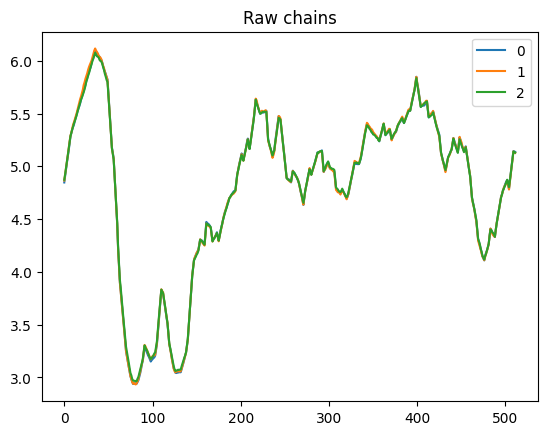

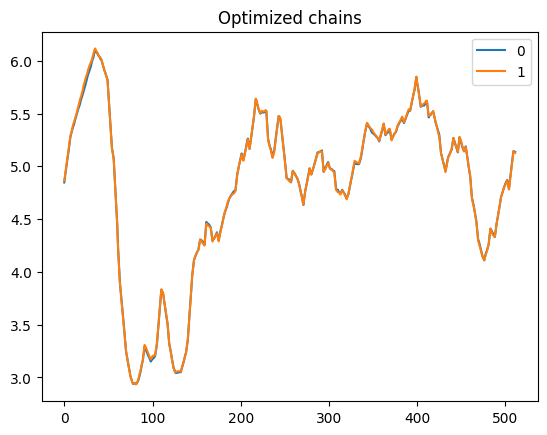

In [100]:
selected_chains = [0, 1]
scou.visualize_latents(selected_chains)

Il nous reste alors une dernière étape : **c'est l'étape 8**. On doit maintenant générer le signal lissé (l'espérance de toute notre distribution). On fait cela à l'aide de la fonction 'predict', en donnant en entrée une liste de chaînes. Ici, je voulais donc conserver les chaînes 0 et 1, je lui donne donc en entrée la liste [0, 1].

In [101]:
selected_chains = [0, 1]
scou.predict(selected_chains)

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.163  0.019   0.130    0.198      0.002    0.001     117.0     334.0   
eps    0.302  0.039   0.235    0.384      0.001    0.001     847.0    1349.0   
p_out  0.053  0.025   0.012    0.099      0.001    0.001    2070.0    1184.0   

       r_hat  
sig     1.02  
eps     1.00  
p_out   1.00  


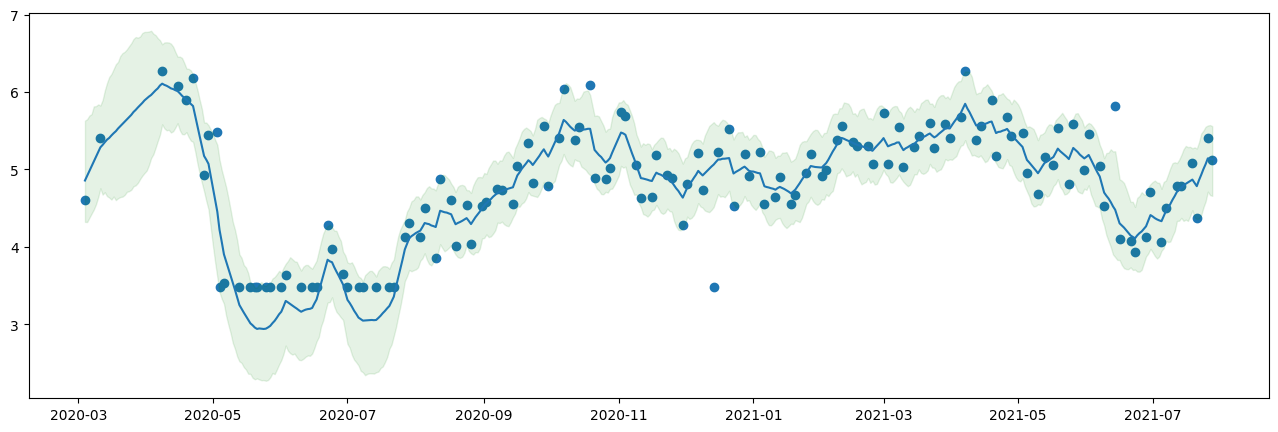

In [102]:
plt.figure(figsize=(16,5))

plt.scatter(raw_data.dateStart.values, raw_data.obs.values)
plt.plot(raw_data.dateStart.values, scou.muX)
plt.fill_between(raw_data.dateStart.values, scou.CIL, scou.CIU, color='green', alpha=0.1)